In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
import utils
from data_utils import CustomDataset
from MLP_utils import load_model, save_model, fix_seed, SimpleMLP, LNLoss
import random
from pathlib import Path
import tempfile
from ray import tune, train
from ray.train import get_checkpoint
from ray.tune.schedulers import FIFOScheduler
import ray.cloudpickle as pickle
import os
import pandas as pd

fix_seed(utils.SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
filenames_features = [utils.FILENAME_BRAND_OHE,
utils.FILENAME_PUBLICATION_TIMESTAMP_EMB,
# utils.FILENAME_PUBLICATION_TIMESTAMP,
utils.FILENAME_PUBLICATION_WEEKDAY_OHE,
utils.FILENAME_NUM_WORDS,
utils.FILENAME_NUM_PARAGRAPH,
# utils.FILENAME_SUBSECTIONS_OHE,
# utils.FILENAME_SUBSECTIONS_OHE,
utils.FILENAME_MAIN_SECTION_EMB,
utils.FILENAME_SUBSECTIONS_EMB,
# utils.FILENAME_MAIN_SECTION_SUBSECTIONS_MEAN_EMB,
utils.FILENAME_USER_NEEDS,
utils.FILENAME_LDA_TOPICS,
utils.FILENAME_IPTC_TOPICS_LEVEL_0,
utils.FILENAME_IPTC_TOPICS_LEVEL_1,
utils.FILENAME_TITLE_EMB,
utils.FILENAME_AUTHOR_OHE,
utils.FILENAME_LABELS_EMB,
utils.FILENAME_TIME_INDICATIONS_MENTIONED_EMB
]

brands = utils.ALL_BRANDS

# brands = ['parool']

customdataset_kwargs = dict(
                        brands=brands, 
                        filenames_features=filenames_features, 
                        dirpath_extracted_features=utils.DIRPATH_EXTRACTED_FEATURES,
                        device=device,
                        log_target=True, 
                        center_target=True,
                        filter_uniform_features=False, 
                        max_datapoints=None)
try:
    dataset = CustomDataset(**customdataset_kwargs)
except torch.cuda.OutOfMemoryError as e:
    print("There was a torch.cuda.OutOfMemoryError. Proceeding with loading the data on the cpu.")
    customdataset_kwargs['device'] = torch.device('cpu')
    dataset = CustomDataset(**customdataset_kwargs)
    
dataset.features.shape[1], dataset.device

(4634, device(type='cuda'))

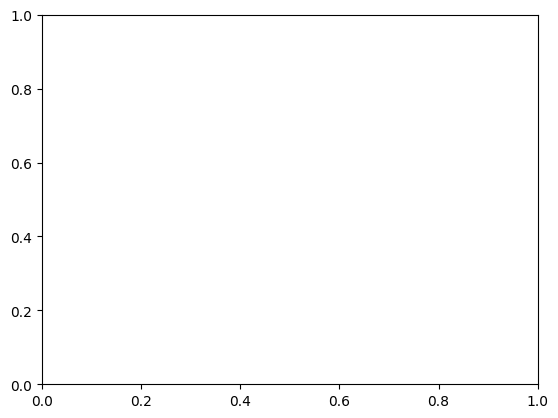

In [3]:
plt.rcParams['figure.facecolor'] = ('white') 
plt.gca().set_facecolor('white')


plt.rcParams["figure.figsize"] = (6.8,7)
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

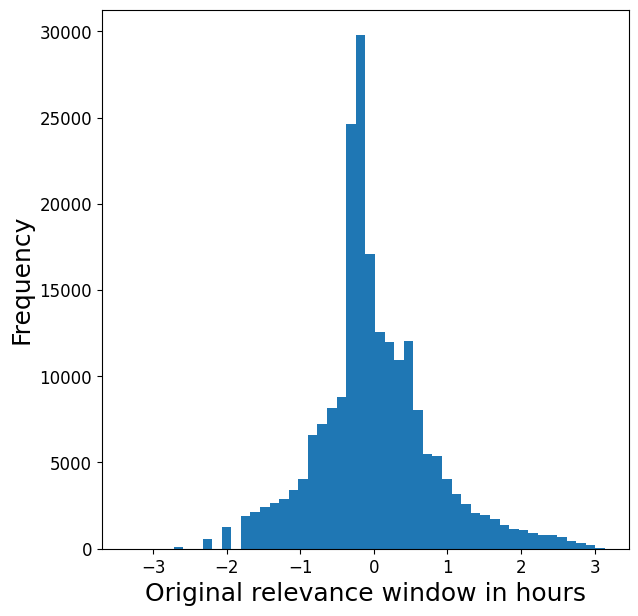

In [4]:
plt.hist(dataset.target.cpu(), bins=50)
plt.ylabel("Frequency")
plt.xlabel("Original relevance window in hours")
plt.show()

In [5]:
def train_MLP(config, dataset, raytune=False, pickle_data_splits=False, verbose=False):
    # fix seed again because Ray Tune seems to change the seed
    fix_seed(utils.SEED)
    hidden_sizes = config["depth"] * [config["width"]]

    model = SimpleMLP(input_size=config["input_size"], hidden_sizes=hidden_sizes, output_size=1, batchnorm=config["batchnorm"], dropout=config["dropout"])
    model.to(device)

    criterion = config["criterion"]
    if config["optimizer"] == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    elif config["optimizer"] == "adamw":
        optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    elif config["optimizer"] == "rmsprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])


    if raytune:
        checkpoint = get_checkpoint()
        if checkpoint:
            with checkpoint.as_directory() as checkpoint_dir:
                data_path = Path(checkpoint_dir) / "data.pkl"
                with open(data_path, "rb") as fp:
                    checkpoint_state = pickle.load(fp)
                start_epoch = checkpoint_state["epoch"]
                model.load_state_dict(checkpoint_state["model_state_dict"])
                optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
        else:
            start_epoch = 0
    else:
        train_loss_epochs = []
        val_loss_epochs = []
        start_epoch = 0

    train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(utils.SEED))
    
    if pickle_data_splits:
        if not os.path.exists(utils.DIRPATH_INDICES):
            os.makedirs(utils.DIRPATH_INDICES)
        with open(os.path.join(utils.DIRPATH_INDICES, 'train_dataset_indices.pkl'), "wb") as fp:
            pickle.dump(train_dataset.indices, fp)  

        with open(os.path.join(utils.DIRPATH_INDICES, 'val_dataset_indices.pkl'), "wb") as fp:
            pickle.dump(val_dataset.indices, fp) 

        with open(os.path.join(utils.DIRPATH_INDICES, 'test_dataset_indices.pkl'), "wb") as fp:
            pickle.dump(test_dataset.indices, fp) 

    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    min_val_loss = float('inf')
    for epoch in range(start_epoch, config["max_epochs"]):  # loop over the dataset multiple times
        train_loss = 0.0
        train_steps = 0
        for data in train_dataloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_steps += 1
            train_loss += loss
        # note that this is not completely correct as the last batch may have had fewer elements so it should actually be a weighted average
        train_loss_epoch = (train_loss / train_steps).item()


        # Validation loss
        val_loss = 0.0
        val_steps = 0
        with torch.no_grad():
            for vdata in val_dataloader:
                vinputs, vlabels = vdata
                vinputs, vlabels = vinputs.to(device), vlabels.to(device)
                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels)
                val_loss += vloss
                val_steps += 1
            val_loss_epoch = (val_loss / val_steps).item()
        

        if raytune:
            with tempfile.TemporaryDirectory() as checkpoint_dir:
                train.report(
                    {"loss": val_loss_epoch},
                )
        else:
            train_loss_epochs.append(train_loss_epoch)
            val_loss_epochs.append(val_loss_epoch)

        if verbose:
            print(f"finished epoch {epoch+1}/{config['max_epochs']} with eval loss {val_loss_epoch:.3f}")

        # Stop trial if validation loss doesn't improve
        if val_loss_epoch < min_val_loss:
            min_val_loss = val_loss_epoch
            counter = 0
        else:
            counter += 1
            if counter == config["patience"]:
                break
        
    if not raytune:
        return model, train_loss_epochs, val_loss_epochs


In [6]:
def short_dirname(trial):
    return "trial_" + str(trial.trial_id)

# Choose amount of trials you want to run
num_samples=50

if device == torch.device('cuda'):
    gpus_per_trial = torch.cuda.device_count()
else:
    gpus_per_trial = 0
cpus_per_trial = 12

config = {
    "criterion": nn.MSELoss(),
    "optimizer": tune.choice([
        "adam", "adamw", "rmsprop", 
                              ]),
    "weight_decay": tune.loguniform(1e-6, 1e-3),
    "depth": tune.randint(2, 6),
    "width": tune.choice([32, 64, 128, 256, 512]),
    "lr": tune.loguniform(1e-5, 1e-3),
    "batch_size": 1024,
    "max_epochs": 50,
    "patience": 3, 
    "batchnorm" :  tune.choice([True, False]),
    "dropout": tune.uniform(0, 0.1),
    "input_size": dataset.features.shape[1],
    "filenames_features": filenames_features,
}

scheduler = FIFOScheduler()

result = tune.run(
    tune.with_parameters(train_MLP, dataset=dataset, raytune=True),
    resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    trial_dirname_creator=short_dirname,
)

best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")

# fix seed again because Ray Tune seems to change the seed
fix_seed(utils.SEED)

2025-02-02 13:37:32,392	INFO worker.py:1832 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2025-02-02 13:37:38,366	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-02-02 13:37:38,368	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,loss
train_MLP_7c82a_00000,0.407582
train_MLP_7c82a_00001,0.392993
train_MLP_7c82a_00002,0.465575
train_MLP_7c82a_00003,0.410956
train_MLP_7c82a_00004,0.38841
train_MLP_7c82a_00005,0.389972
train_MLP_7c82a_00006,0.387956
train_MLP_7c82a_00007,0.375513
train_MLP_7c82a_00008,0.389028
train_MLP_7c82a_00009,0.410685


2025-02-02 14:05:59,833	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/Admin/ray_results/train_MLP_2025-02-02_13-37-38' in 0.0375s.
2025-02-02 14:05:59,847	INFO tune.py:1041 -- Total run time: 1701.48 seconds (1701.40 seconds for the tuning loop).


Best trial config: {'criterion': MSELoss(), 'optimizer': 'adam', 'weight_decay': 0.00039931079168018907, 'depth': 3, 'width': 256, 'lr': 7.069564548473013e-05, 'batch_size': 1024, 'max_epochs': 50, 'patience': 3, 'batchnorm': False, 'dropout': 0.09829492149373525, 'input_size': 4634, 'filenames_features': ['brand_ohe.pt', 'publication_timestamp_emb.pt', 'publication_weekday_ohe.pt', 'num_words.pt', 'num_paragraph.pt', 'main_section_emb.pt', 'subsections_emb.pt', 'user_needs.pt', 'lda_topics.pt', 'iptc_topics_level_0.pt', 'iptc_topics_level_1.pt', 'title_emb.pt', 'author_ohe.pt', 'labels_emb.pt', 'time_indications_mentioned_emb.pt']}
Best trial final validation loss: 0.37000206112861633


In [15]:
mean = 0
for i, trial in enumerate(result.results):
	mean += result.results[trial]['loss']
mean / (i+1)

0.3900644248723984

In [8]:
retrain_config = best_trial.config

In [9]:
model, train_loss, val_loss = train_MLP(config=retrain_config, dataset=dataset, verbose=True)


finished epoch 1/50 with eval loss 0.570
finished epoch 2/50 with eval loss 0.504
finished epoch 3/50 with eval loss 0.460
finished epoch 4/50 with eval loss 0.431
finished epoch 5/50 with eval loss 0.415
finished epoch 6/50 with eval loss 0.407
finished epoch 7/50 with eval loss 0.398
finished epoch 8/50 with eval loss 0.396
finished epoch 9/50 with eval loss 0.389
finished epoch 10/50 with eval loss 0.390
finished epoch 11/50 with eval loss 0.391
finished epoch 12/50 with eval loss 0.382
finished epoch 13/50 with eval loss 0.380
finished epoch 14/50 with eval loss 0.377
finished epoch 15/50 with eval loss 0.377
finished epoch 16/50 with eval loss 0.376
finished epoch 17/50 with eval loss 0.388
finished epoch 18/50 with eval loss 0.377
finished epoch 19/50 with eval loss 0.374
finished epoch 20/50 with eval loss 0.377
finished epoch 21/50 with eval loss 0.374
finished epoch 22/50 with eval loss 0.373
finished epoch 23/50 with eval loss 0.374
finished epoch 24/50 with eval loss 0.371
f

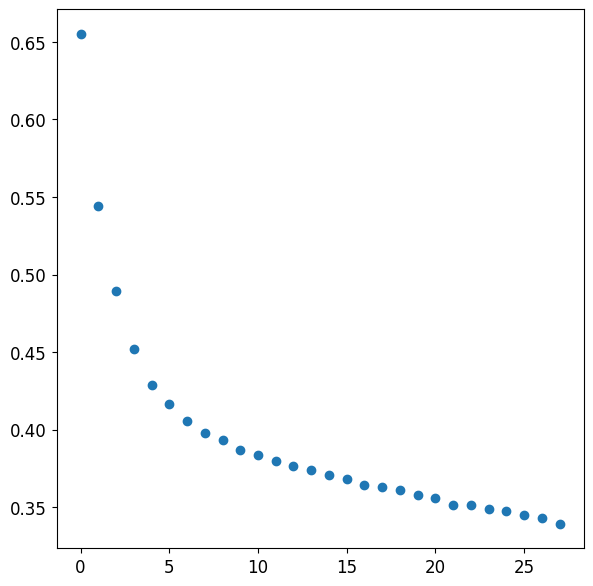

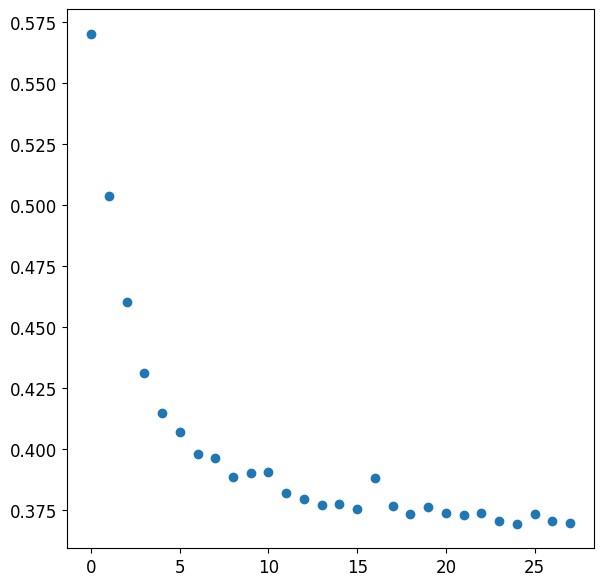

In [10]:
plt.scatter(range(len(train_loss)), train_loss)
plt.show()
plt.scatter(range(len(val_loss)), val_loss)
plt.show()

In [11]:
# Save model
save_model(model, retrain_config, 'last_run')

In [12]:
# Load model
model, config = load_model('last_run', device=device)

In [13]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(utils.SEED))


In [14]:
import math

with torch.no_grad():
	metric = nn.MSELoss(reduction='none')
	# metric = nn.L1Loss(reduction='none')
	# metric = retrain_config["criterion"]
	# metric.reduction = 'none'
	model.eval()

	y_train = dataset[train_dataset.indices][1].cpu()
	y_pred_train = model(dataset[train_dataset.indices][0]).cpu()
	metric_scores_train = metric(y_pred_train, y_train)

	y_val = dataset[val_dataset.indices][1].cpu()
	y_pred_val = model(dataset[val_dataset.indices][0]).cpu()
	metric_scores_val = metric(y_pred_val, y_val)

	y_test = dataset[test_dataset.indices][1].cpu()
	y_pred_test = model(dataset[test_dataset.indices][0]).cpu()
	metric_scores_test = metric(y_pred_test, y_test)

	target_test = test_dataset.dataset[test_dataset.indices][1] + dataset.centering_shift
	baseline = torch.full_like(target_test, math.log(24))
	baseline_metric = metric(target_test, baseline).cpu()

print(metric_scores_train.mean(), metric_scores_train.std())
print(metric_scores_val.mean(), metric_scores_val.std())
print(metric_scores_test.mean(), metric_scores_test.std())
print("baseline:")
print(baseline_metric.mean(), baseline_metric.std())


tensor(0.3295) tensor(0.7215)
tensor(0.3651) tensor(0.7966)
tensor(0.3786) tensor(0.8333)
baseline:
tensor(0.6725) tensor(1.2802)


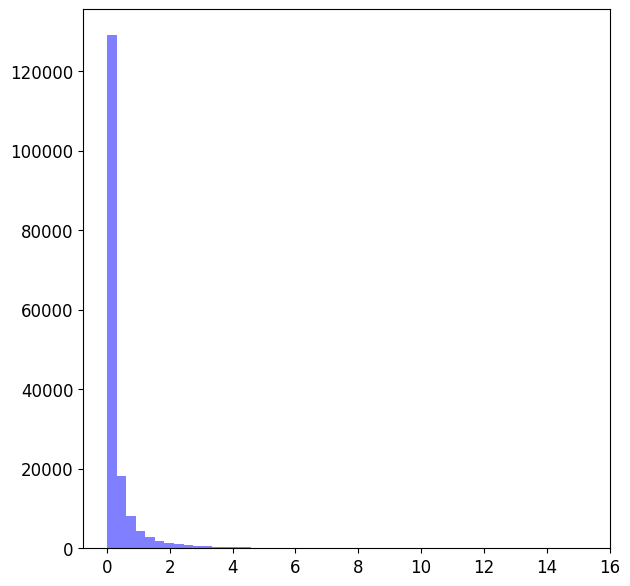

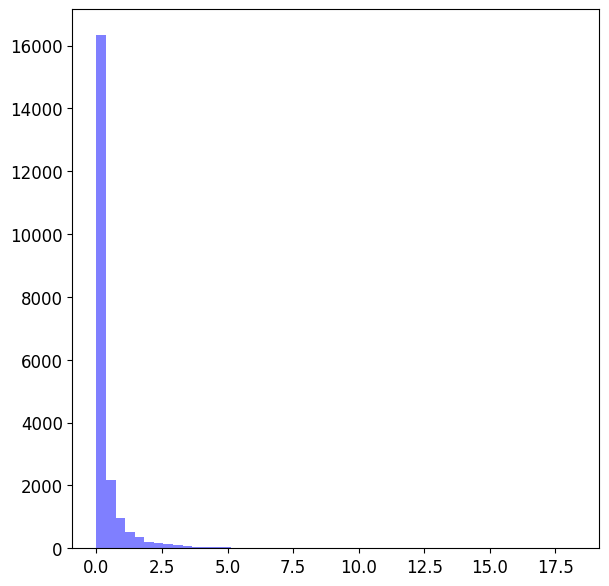

In [17]:
plt.hist(metric_scores_train, bins=50, alpha=0.5, color='b')
plt.show()
plt.hist(metric_scores_test, bins=50, alpha=0.5, color='b')
plt.show()

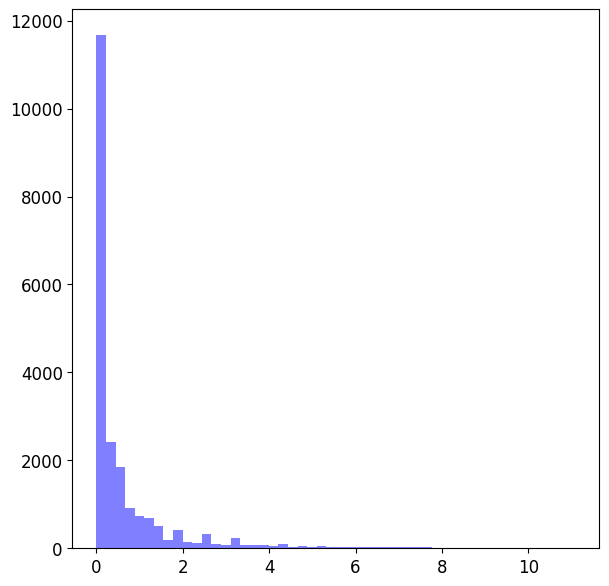

In [15]:
plt.hist(baseline_metric.cpu(), bins=50, alpha=0.5, color='b')
plt.show()

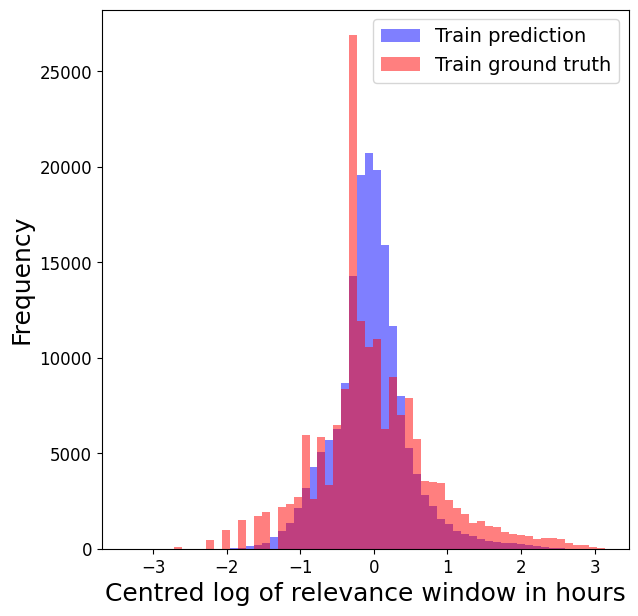

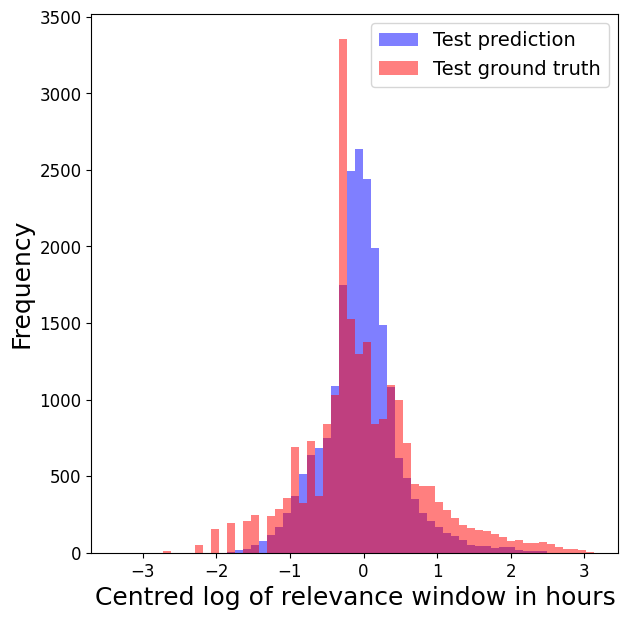

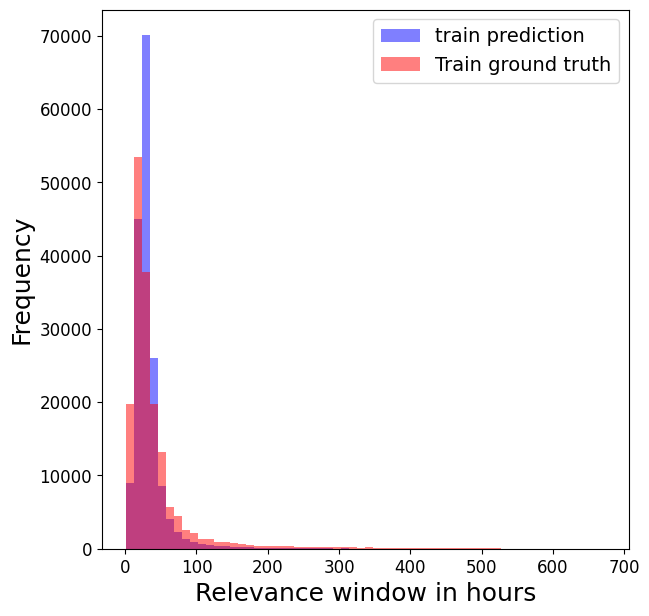

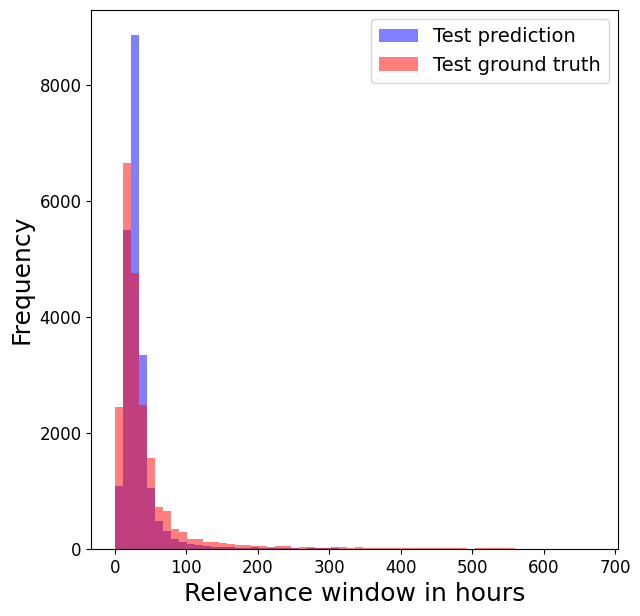

In [16]:
n_bins = 60
bins = np.histogram(np.hstack((y_pred_train,y_train)), bins=n_bins)[1]
plt.hist(y_pred_train, bins=bins, alpha=0.5, color='b', label='Train prediction')
plt.hist(y_train, bins=bins, alpha=0.5, color='r', label='Train ground truth')
plt.legend()
plt.xlabel("Centred log of relevance window in hours")
plt.ylabel("Frequency")
plt.show()

bins = np.histogram(np.hstack((y_pred_test,y_test)), bins=n_bins)[1]
plt.hist(y_pred_test, bins=bins, alpha=0.5, color='b', label='Test prediction')
plt.hist(y_test, bins=bins, alpha=0.5, color='r', label='Test ground truth')
plt.legend()
plt.xlabel("Centred log of relevance window in hours")
plt.ylabel("Frequency")
plt.show()

y_pred_train_trans = y_pred_train
y_train_trans = y_train
y_pred_test_trans = y_pred_test
y_test_trans = y_test

if dataset.center_target:
    centering_shift = dataset.centering_shift.cpu()
    y_pred_train_trans = y_pred_train_trans + centering_shift
    y_train_trans = y_train_trans + centering_shift
    y_pred_test_trans = y_pred_test_trans + centering_shift
    y_test_trans = y_test_trans + centering_shift
if dataset.log_target:
    y_pred_train_trans = torch.exp(y_pred_train_trans)
    y_train_trans = torch.exp(y_train_trans)
    y_pred_test_trans = torch.exp(y_pred_test_trans)
    y_test_trans = torch.exp(y_test_trans)
else:
    y_pred_train_trans = torch.log(y_pred_train_trans)
    y_train_trans = torch.log(y_train_trans)
    y_pred_test_trans = torch.log(y_pred_test_trans)
    y_test_trans = torch.log(y_test_trans)


bins = np.histogram(np.hstack((y_pred_train_trans,y_train_trans)), bins=n_bins)[1]
plt.hist(y_pred_train_trans, bins=bins, alpha=0.5, color='b', label='train prediction')
plt.hist(y_train_trans, bins=bins, alpha=0.5, color='r', label='Train ground truth')
plt.legend()
plt.xlabel("Relevance window in hours")
plt.ylabel("Frequency")
plt.show()

bins = np.histogram(np.hstack((y_pred_test_trans,y_test_trans)), bins=n_bins)[1]
plt.hist(y_pred_test_trans, bins=bins, alpha=0.5, color='b', label='Test prediction')
plt.hist(y_test_trans, bins=bins, alpha=0.5, color='r', label='Test ground truth')
plt.legend()
plt.xlabel("Relevance window in hours")
plt.ylabel("Frequency")
plt.show()